<a href="https://colab.research.google.com/github/RohanPalivela/W3BHackathon/blob/main/Wind_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Upload Kaggle API key
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mubashirrahim/wind-power-generation-data-forecasting

!mkdir -p /content/kaggle/input
!unzip wind-power-generation-data-forecasting.zip -d /content/kaggle/input

Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting
License(s): CC0-1.0
  0% 0.00/3.32M [00:00<?, ?B/s]
100% 3.32M/3.32M [00:00<00:00, 82.5MB/s]
Archive:  wind-power-generation-data-forecasting.zip
  inflating: /content/kaggle/input/Location1.csv  
  inflating: /content/kaggle/input/Location2.csv  
  inflating: /content/kaggle/input/Location3.csv  
  inflating: /content/kaggle/input/Location4.csv  
  inflating: /content/kaggle/input/readme.txt  


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
data_1 = pd.read_csv('/content/kaggle/input/Location1.csv')
data_2 = pd.read_csv('/content/kaggle/input/Location2.csv')
data_3 = pd.read_csv('/content/kaggle/input/Location3.csv')
data_4 = pd.read_csv('/content/kaggle/input/Location4.csv')

combined_data= pd.concat([data_1, data_2, data_3, data_4], ignore_index=True)

combined_data = combined_data.dropna()

combined_data = combined_data.drop(columns=['Time','windspeed_100m','windgusts_10m','winddirection_100m','dewpoint_2m'])
print(combined_data.head())


   temperature_2m  relativehumidity_2m  windspeed_10m  winddirection_10m  \
0            28.5                   85           1.44                146   
1            28.4                   86           2.06                151   
2            26.8                   91           1.30                148   
3            27.4                   88           1.30                 58   
4            27.3                   88           2.47                 58   

    Power  
0  0.1635  
1  0.1424  
2  0.1214  
3  0.1003  
4  0.0793  


In [76]:
y = combined_data['Power']
X = combined_data.drop(columns=['Power'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [49]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
# Train PLS Regression Model
pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = pls.predict(X_test)
y_pred2 = pls.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 0.19319704098340326
R²: 0.44119490131016814


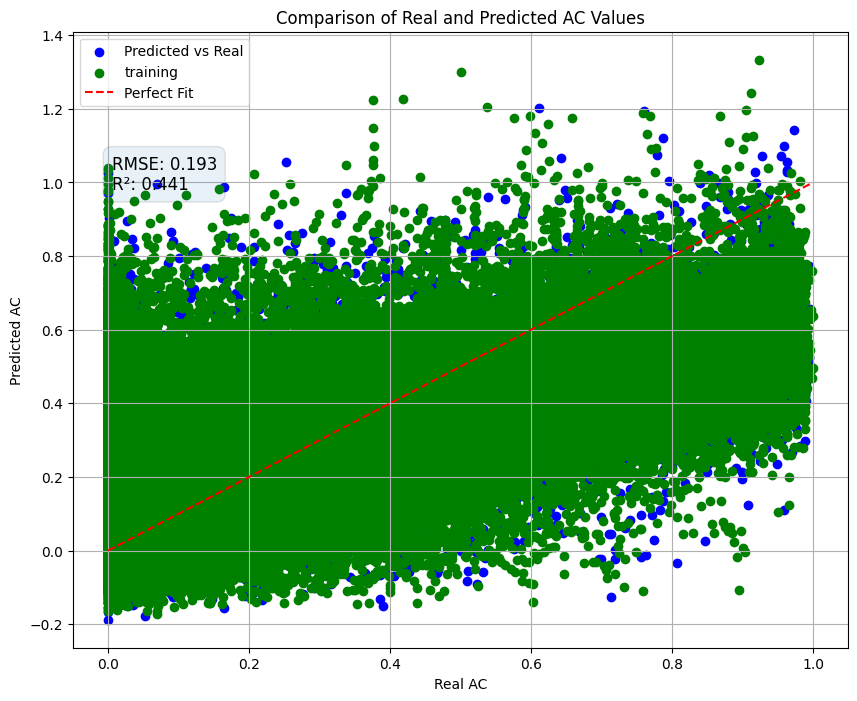

In [50]:
# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Real')
plt.scatter(y_train, y_pred2, color='green', label='training')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
plt.text(x=0.05, y=0.8, s=f'RMSE: {rmse:.3f}\nR²: {r2:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1))

plt.xlabel('Real AC')
plt.ylabel('Predicted AC')
plt.title('Comparison of Real and Predicted AC Values')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_score = lr_model.score(X_test, y_test)
print(f"Score is {lr_score*100:.4f} %")

Score is 32.8477 %


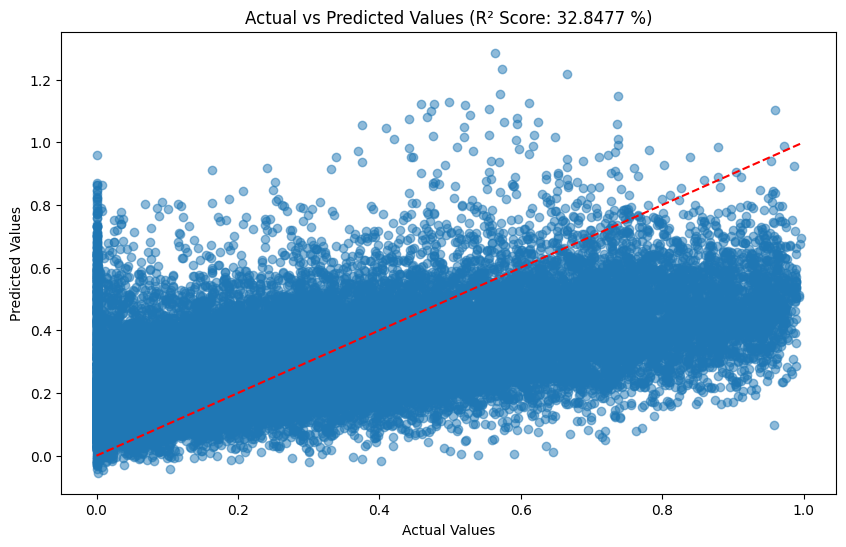

In [80]:
# Assuming you have already trained your Linear Regression model and have your predictions
y_pred = lr_model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R² Score: {lr_score*100:.4f} %)')
plt.show()


In [81]:
from sklearn import neighbors

score_list = []
n_neighbors_list = []

# for loop to find best fitting n_neighbor value
for i in range(1, 21):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)

    knn_score = knn.score(X_test, y_test)

    score_list.append(knn_score)
    n_neighbors_list.append(i)

best_n_neighbor = n_neighbors_list[score_list.index(max(score_list))]
print(f"Best n_neighbor at {best_n_neighbor} with {max(score_list)*100:.4f} %")

Best n_neighbor at 9 with 34.3727 %


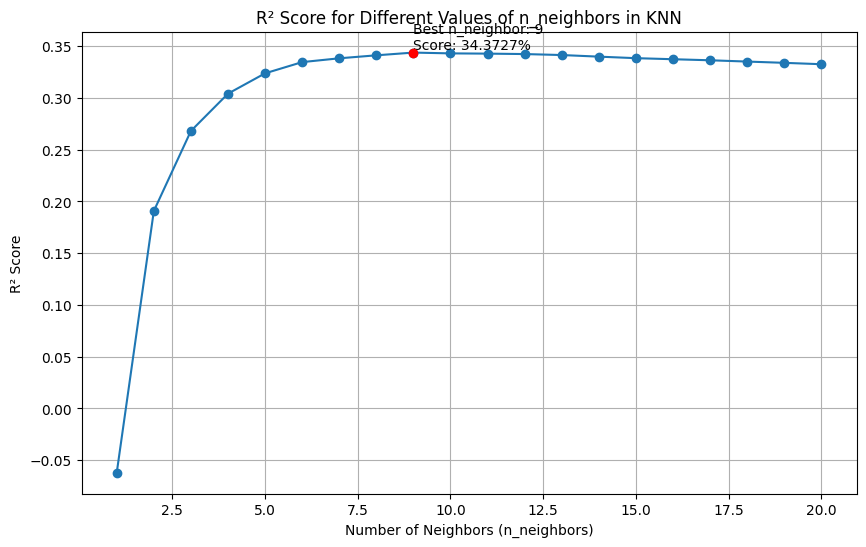

Best n_neighbor at 9 with 34.3727 %


In [83]:
import matplotlib.pyplot as plt

# Assuming you have run the loop and have your score_list and n_neighbors_list
# Plot the scores against the number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_list, score_list, marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('R² Score')
plt.title('R² Score for Different Values of n_neighbors in KNN')
plt.grid(True)

# Highlight the best n_neighbors
best_n_neighbor = n_neighbors_list[score_list.index(max(score_list))]
best_score = max(score_list)
plt.scatter([best_n_neighbor], [best_score], color='red', zorder=5)
plt.text(best_n_neighbor, best_score, f'Best n_neighbor: {best_n_neighbor}\nScore: {best_score*100:.4f}%',
         horizontalalignment='left', verticalalignment='bottom')

plt.show()

print(f"Best n_neighbor at {best_n_neighbor} with {best_score*100:.4f} %")

In [85]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

dtr_score = dtr.score(X_test, y_test)
print(f"Score is {dtr_score*100:.4f} %")

Score is -4.8182 %


In [84]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

rfr_score = model.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 41.0351 %


In [77]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

base_models = [
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor())
]
meta_model = LinearRegression()



stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

rfr_score = stacking_model.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 45.4591 %


In [78]:
from joblib import dump, load
dump(stacking_model, 'model.joblib')

['model.joblib']

In [86]:
files.download('model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
from google.cloud import storage

client = storage.Client()
bucket_name = 'your-bucket-name'
source_file_name = 'model.joblib'
destination_blob_name = 'model.joblib'

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)
blob = bucket.blob(destination_blob_name)
url = blob.public_url
print(f'Model URL: {url}')


RefreshError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7bba9ef11cc0>)

In [63]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
model.fit(X_train, y_train)

rfr_score = model.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 1.3088 %


In [57]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

rfr_score = rfr.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 57.8743 %


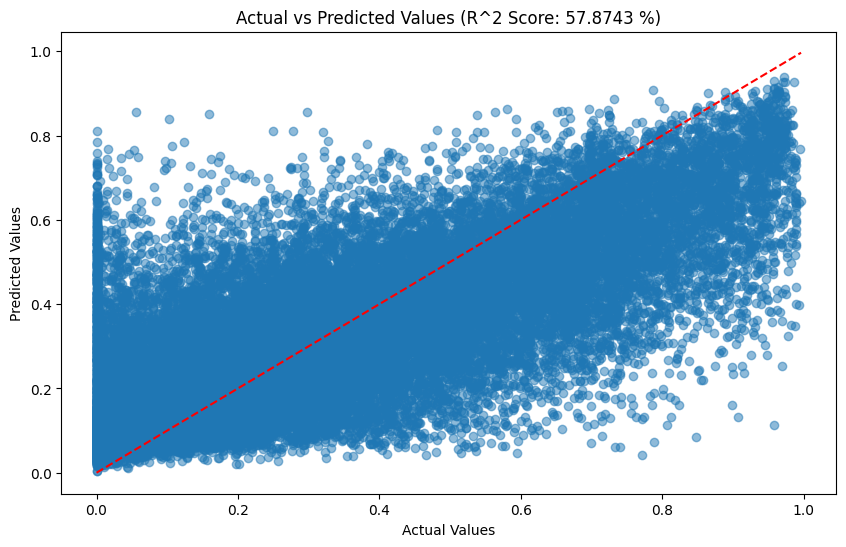

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained your RandomForestRegressor and have your predictions
y_pred = rfr.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of best fit
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R^2 Score: {rfr_score*100:.4f} %)')
plt.show()